In [1]:
import os
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from copy import deepcopy
from pylab import rcParams

import openeye
from openeye import oechem
from samplingtools import *
from smarty import *
from smarty import ForceField
from smarty.utils import get_data_filename

In [2]:
%matplotlib inline

/Users/guilhermematos/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/Users/guilhermematos/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/Users/guilhermematos/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/Users/guilhermematos/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'confi

In [17]:
# Functions
def calculate_energies(smirk, key,
                       modify_key_by_type,
                       prange, number_of_points,
                       copyff, oemol, topology):
    xaxis = np.linspace(prange[key][0],prange[key][1], number_of_points)
    energies = np.zeros(len(xaxis))
    params = copyff.getParameter(smirks=smirk)
    backup = params.copy()
    for idx, element in enumerate(xaxis):
        params[key] = str(element)
        copyff.setParameter(params,smirks=smirk)
        system = copyff.createSystem(topology, [oemol])
        cpos = reformat_oemol_coordinates(oemol)
        energies[idx] = get_energy(system,cpos[:,:,0])
    return xaxis, energies

def gaussian(mean, std, x):
    y = (1/(std *np.sqrt(2*np.pi)))*np.exp(-0.5*((x-mean)/std)**2)
    return y

def log_likelihood( z, mu, s_E):
    """Calculate a log likelihood and a likelihood given a calculated value, a set of `measured`/observed values
        (data we are fitting to) and a standard error in those measured values.
        
        
        Parameters
        ----------
        z : simtk.unit.Quantity of dimensions N
        Calculated values
        mu : simtk.unit.Quantity of dimensions N
        Mean (i.e. observed/measured values)
        s_E : simtk.unit.Quantity of dimensions N
        Standard error in the mean (uncertainty in observed/measured values)
        
        Returns
        -------
        loglike : float
        Natural logarithm of likelihood
        like : float
        Likelihood
        """
    # Adapted from https://github.com/shirtsgroup/lj_bayesian/blob/041b896d37f91f4b42cccb2df73af84a9cf5b917/generate_posterior.py#L117
    
    
    # Standardize units of input and strip units, if they have units
    try:
        unit_choice = z.unit
        clear_s_E = s_E.value_in_unit(unit_choice)
        clear_mu = mu.value_in_unit(unit_choice)
        clear_z = z.value_in_unit(unit_choice)
    except AttributeError:
        clear_s_E = s_E
        clear_mu = mu
        clear_z = z
    # If we've mixed things with units with things without units, the below will raise another attribute error
    
    # Compute log likelihood and likelihood
    # Gaussian is (2*pi*s_E^2)^(-1/2) e^(-(z-mu)^2 /2s_E^2)
    # log Gaussian is -1/2 * (log(2*pi) + 2*log(s_E)) -|z-mu|^2/(2s_E^2)
    # Here we will ignore the constant term because it drops out when taking ratios of probabilities
    loglike = 0.
    like = 0.
    for i, m in enumerate(clear_mu):
        this_s_E = clear_s_E[i]
        this_z = clear_z[i]
        gauss_arg = - ((m-this_z)**2)/(2.*this_s_E**2)
        loglike += gauss_arg - 0.5*np.log(2*np.pi*this_s_E**2)
    
    like = np.exp(loglike)
    return loglike, like

In [4]:
# Load pre-generated data if already generated, otherwise re-generate
if os.path.isfile('ref_energies.pickle') and os.path.isfile('topologies.pickle') and os.path.isfile('oemols_molnames.pickle'):
    file = open('ref_energies.pickle', 'r')
    ref_energies = pickle.load(file)
    file.close()
    file = open('topologies.pickle', 'r')
    topologies = pickle.load(file)
    file = open('oemols_molnames.pickle', 'r')
    oemols, mol_names = pickle.load(file)
    file.close()
    print("Loaded reference data.")
else:
    print("Re-generating reference data.")
    os.system('python generate_reference_data.py')
    file = open('ref_energies.pickle', 'r')
    ref_energies = pickle.load(file)
    file.close()
    file = open('topologies.pickle', 'r')
    topologies = pickle.load(file)
    file = open('oemols_molnames.pickle', 'r')
    oemols, mol_names = pickle.load(file)
    file.close()
    print("Loaded reference data.")

if os.path.isfile('s_E_mean.pickle'):
    file = open('s_E_mean.pickle', 'r')
    s_E, mean_unc = pickle.load(file)
    file.close()
else:
    print("Re-generating uncertainty data.")
    os.system('python get_uncertainties.py')
    file = open('s_E_mean.pickle', 'r')
    s_E, mean_unc = pickle.load(file)
    file.close()

Loaded reference data.


In [5]:
# Get force field data, parameter types, ranges and smirk labels
# Get force field
ffxml = get_data_filename('forcefield/Frosst_AlkEtOH.ffxml')
ff = forcefield.ForceField(ffxml)
# Define parameter range to consider
prange = {'rmin_half':[0.0, 3.], 'epsilon':[0.0, 0.1], 'length':[0.0,2.0], 'k':[0.,2000.], 'angle':[0.,180.]}
# What keys to modify for each smirks
modify_key_by_type = {'n':['rmin_half', 'epsilon'],'b':['length', 'k'], 'a':['angle','k'],'t':['k','periodicity','phase'], 'i':['k','periodicity','phase']}
# Figure out how to determine which molecules use the SMIRKS we're interested in
labels = ff.labelMolecules(oemols,verbose=False)

In [6]:
# Define molecule of interest
mol =  oemols[0]
top = topologies[0]
mu_E = ref_energies[0] # mean_unc is the associated uncertainty
# Create copy of the force field
copyff = deepcopy(ff)
copyff2 = deepcopy(ff)

In [7]:
molecule = pd.DataFrame.from_dict(labels[0],orient='index')
molecule

,0,1,2,3,4,5
HarmonicBondGenerator,"([0, 1], b0002, [#6X4:1]-[#1:2])","([0, 3], b0002, [#6X4:1]-[#1:2])","([0, 2], b0002, [#6X4:1]-[#1:2])","([0, 4], b0002, [#6X4:1]-[#1:2])",None,None
PeriodicTorsionGenerator,None,None,None,None,None,None
NonbondedGenerator,"([2], n0002, [$([#1]-[#6]):1])","([0], n0008, [#6X4:1])","([3], n0002, [$([#1]-[#6]):1])","([1], n0002, [$([#1]-[#6]):1])","([4], n0002, [$([#1]-[#6]):1])",None
HarmonicAngleGenerator,"([1, 0, 3], a0002, [#1:1]-[#6X4:2]-[#1:3])","([2, 0, 3], a0002, [#1:1]-[#6X4:2]-[#1:3])","([2, 0, 4], a0002, [#1:1]-[#6X4:2]-[#1:3])","([3, 0, 4], a0002, [#1:1]-[#6X4:2]-[#1:3])","([1, 0, 4], a0002, [#1:1]-[#6X4:2]-[#1:3])","([1, 0, 2], a0002, [#1:1]-[#6X4:2]-[#1:3])"


In [8]:
params = copyff.getParameter(smirks='[#6X4:1]-[#1:2]')
backup = params.copy()
parm_table = pd.DataFrame.from_dict(params,orient='index')
parm_table.columns = ['property']
parm_table

,property
smirks,[#6X4:1]-[#1:2]
length,1.090
k,680.0
parent_id,b0002
id,b0002


According to ```Frost_AlkEtOH.ffxml```, the unit of length is angstrom ($ {\buildrel _{\circ} \over {\mathrm{A}}}$) and the unit of k is $kcal \cdot mol^{-1}\cdot {\buildrel _{\circ} \over {\mathrm{A}}}^{-2}$.

```b0002``` bond properties:
* length = 1.090
* k = 680.0

In [10]:
# calculate variables to be plotted
lengths, E_r = calculate_energies('[#6X4:1]-[#1:2]', 'length',
                       modify_key_by_type,
                       prange, 300,
                       copyff, mol, top)

ks, E_k = calculate_energies('[#6X4:1]-[#1:2]', 'k',
                       modify_key_by_type,
                       prange, 300,
                       copyff2, mol, top)


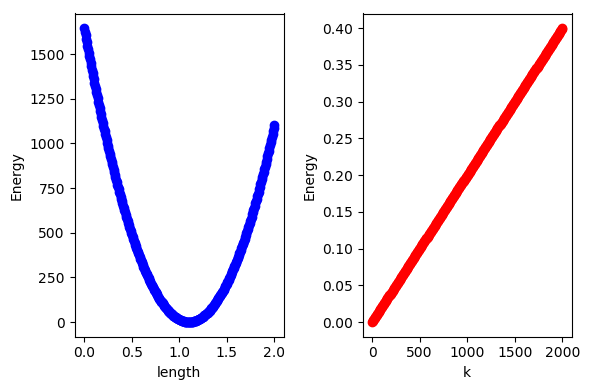

In [11]:
# Plot energies
fig = pl.figure()

ax1 = fig.add_subplot(121)
ax1.plot(lengths, E_r, 'bo')
ax1.set_xlabel(r'length')
ax1.set_ylabel('Energy')

ax2 = fig.add_subplot(122)
ax2.plot(ks, E_k, 'ro')
ax2.set_xlabel(r'k')
ax2.set_ylabel('Energy')

pl.tight_layout()

In [14]:
# Calculate likelihoods
# Storage
likelihood_lengths = np.zeros(len(lengths))
likelihood_ks = np.zeros(len(ks))

# likelihood distribution of bond lengths
for idx, energy in enumerate(E_r):
    loglike, like = log_likelihood([energy],[mu_E],[mean_unc])
    likelihood_lengths[idx] = like
    
# likelihood distribution of bond ks
for idx, energy in enumerate(E_k):
    loglike, like = log_likelihood([energy],[mu_E],[mean_unc])
    likelihood_ks[idx] = like

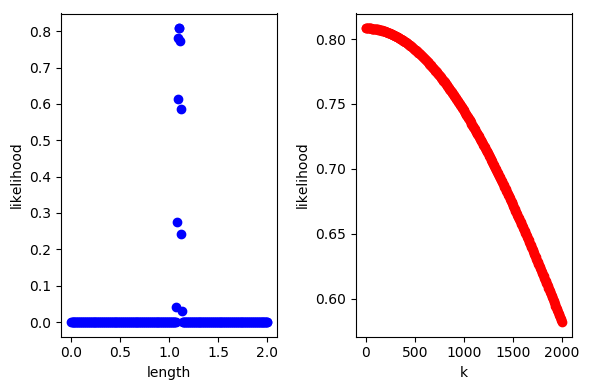

In [15]:
# Plot likelihoods
fig = pl.figure()

ax1 = fig.add_subplot(121)
ax1.plot(lengths, likelihood_lengths, 'bo')
ax1.set_xlabel(r'length')
ax1.set_ylabel('likelihood')

ax2 = fig.add_subplot(122)
ax2.plot(ks, likelihood_ks, 'ro')
ax2.set_xlabel(r'k')
ax2.set_ylabel('likelihood')

pl.tight_layout()

(0.0, 1.4)

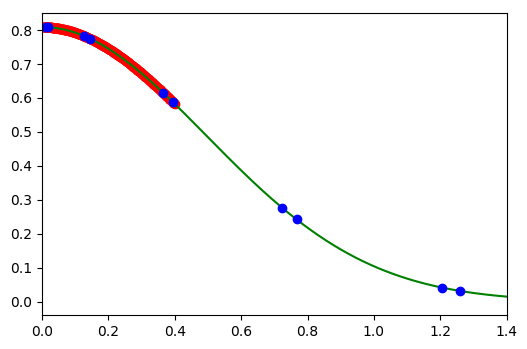

In [25]:
en_axis = np.linspace(0.0,mu_E+3*mean_unc,200)
likelihoods = gaussian(mu_E,mean_unc,en_axis)

fig = pl.figure()
ax = fig.add_subplot(111)
ax.plot(E_k,likelihood_ks,'ro')
ax.plot(en_axis,likelihoods,'g-')
ax.plot(E_r,likelihood_lengths,'bo')
ax.set_xlim(0.0,1.4)

Let's reset and try again. Perhaps a parameter likelihood map can help.

In [26]:
# Define elements
# Get force field
ffxml = get_data_filename('forcefield/Frosst_AlkEtOH.ffxml')
ff = ForceField(ffxml)
# Define parameter range to consider and move range
prange = {'length':[0.9,1.2],'k':[10.,1800.]}
# Define smirk to be tested
smirk = '[#6X4:1]-[#1:2]'
# Create calculation points
ks = np.linspace(prange['k'][0], prange['k'][1], 100)
lengths = np.linspace(prange['length'][0], prange['length'][1], 100)
X,Y = np.meshgrid(ks,lengths)
points = np.array([X.flatten(),Y.flatten()]).T

In [27]:
# Calculate energies
energies = np.zeros(len(points))
for idx, point in enumerate(points):
    params['k'] = str(point[0])
    params['length'] = str(point[1])
    ff.setParameter(params,smirks=smirk)
    system = ff.createSystem(top,[mol])
    cpos = reformat_oemol_coordinates(mol)
    calcE = get_energy(system,cpos[:,:,0])
    energies[idx] = calcE

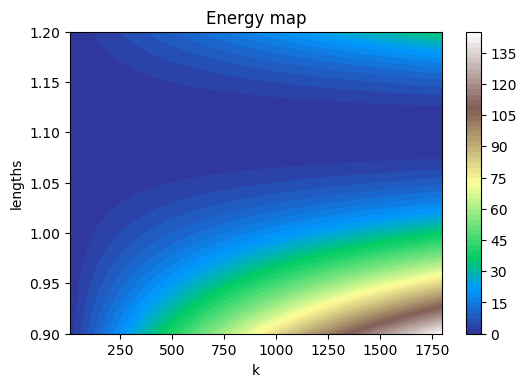

In [29]:
# Plot energy map
energy_matrix = energies.reshape((100,100))

pl.figure()
pl.contourf(ks,lengths,energy_matrix,60,cmap='terrain')
pl.colorbar()
pl.xlabel('k')
pl.ylabel('lengths')
pl.title('Energy map')


In [30]:
# Calculate log likelihoods and likelihoods
loglikes = np.zeros(len(energies))
likes = np.zeros(len(energies))

for idx, energy in enumerate(energies):
    loglikes[idx], likes[idx] = log_likelihood([energy],[mu_E],[mean_unc])

In [31]:
loglike_matrix = loglikes.reshape((100,100))
like_matrix = likes.reshape((100,100))

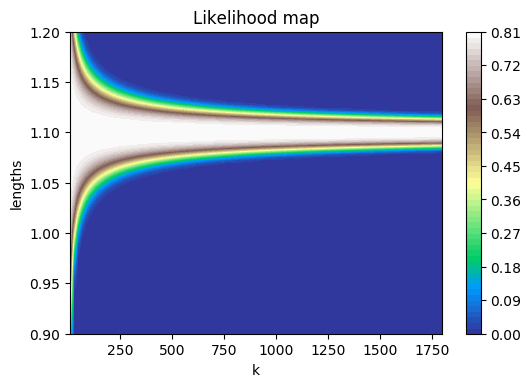

In [32]:
#Plot likelihood map
pl.figure()
pl.contourf(ks,lengths,like_matrix,60,cmap='terrain')
pl.colorbar()
pl.xlabel('k')
pl.ylabel('lengths')
pl.title('Likelihood map')

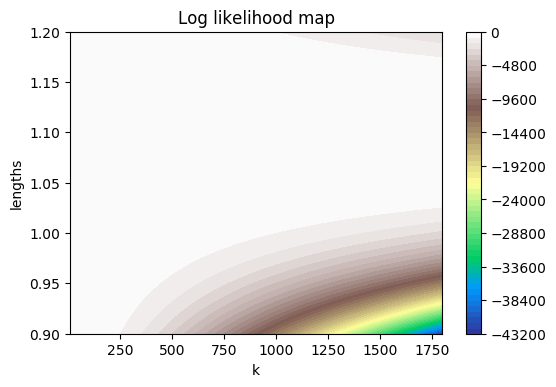

In [33]:
#Plot likelihood map
pl.figure()
pl.contourf(ks,lengths,loglike_matrix,60,cmap='terrain')
pl.colorbar()
pl.xlabel('k')
pl.ylabel('lengths')
pl.title('Log likelihood map')